In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf

from keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.callbacks import History, Callback
from keras.applications.vgg16 import VGG16

In [2]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [3]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class_{i}'][-1] for i in range(10)]
    recall_values = [history.history[f'recall_class_{i}'][-1] for i in range(10)]

    classes = [str(i) for i in range(10)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(12, 6))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [4]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data_rgb = np.stack((train_data,) * 3, axis=-1)
test_data_rgb = np.stack((test_data,) * 3, axis=-1)

train_data_rgb = tf.image.resize(train_data_rgb, (32, 32))
test_data_rgb = tf.image.resize(test_data_rgb, (32, 32))

train_data_rgb, test_data_rgb = train_data_rgb / 255., test_data_rgb / 255.

train_labels_one_hot = to_categorical(train_labels, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)

In [5]:
precision_per_class = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(10)]
recall_per_class = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(10)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [6]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

class MyFilterModelMP():
    def build(self):
        model = Sequential([
            conv_base,
            Flatten(),
            Dense(
                units=64,
                activation='relu'
            ),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model


In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    vertical_flip=True
)

train_generator = datagen.flow(train_data_rgb, train_labels_one_hot, batch_size=32)
test_generator = datagen.flow(test_data_rgb, test_labels_one_hot, batch_size=32)

In [8]:
filtermodel = MyFilterModelMP()
model_filter = filtermodel.build()
history = model_filter.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=50,
    epochs=100,
    batch_size=32
)

Epoch 1/100


100/100 [==============================] - 15s 127ms/step - loss: 1.5153 - accuracy: 0.5362 - precision_class_0: 0.7308 - precision_class_1: 0.9625 - precision_class_2: 0.7826 - precision_class_3: 0.8108 - precision_class_4: 0.7368 - precision_class_5: 0.9241 - precision_class_6: 0.7143 - precision_class_7: 0.8161 - precision_class_8: 0.9762 - precision_class_9: 0.9306 - recall_class_0: 0.0572 - recall_class_1: 0.4828 - recall_class_2: 0.0596 - recall_class_3: 0.0890 - recall_class_4: 0.0453 - recall_class_5: 0.2378 - recall_class_6: 0.0152 - recall_class_7: 0.2219 - recall_class_8: 0.1340 - recall_class_9: 0.1976 - val_loss: 1.0655 - val_accuracy: 0.6500 - val_precision_class_0: 0.7077 - val_precision_class_1: 0.9180 - val_precision_class_2: 0.7500 - val_precision_class_3: 0.7705 - val_precision_class_4: 0.8182 - val_precision_class_5: 0.9123 - val_precision_class_6: 0.6000 - val_precision_class_7: 0.7852 - val_precision_class_8: 0.9412 - val_precision_class_9: 0.9727 - 

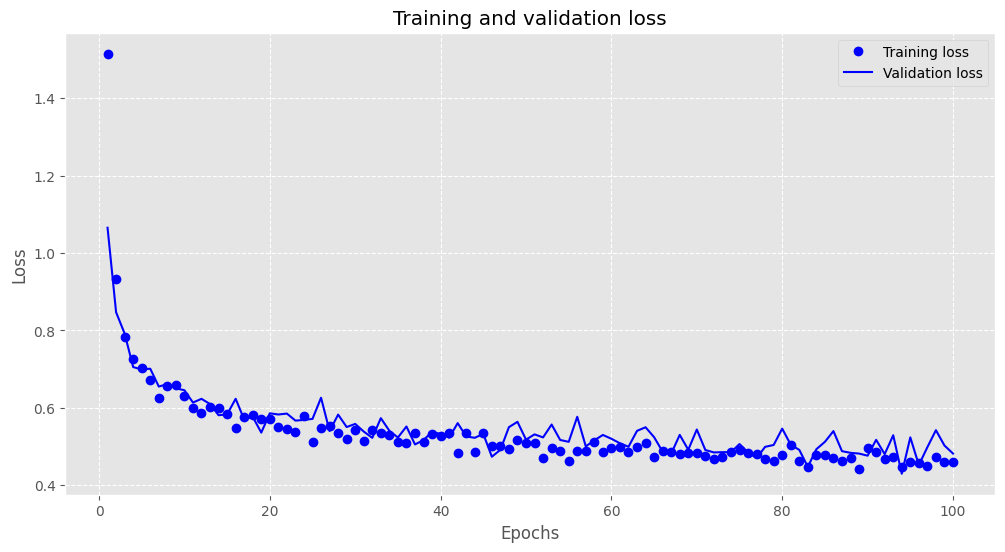

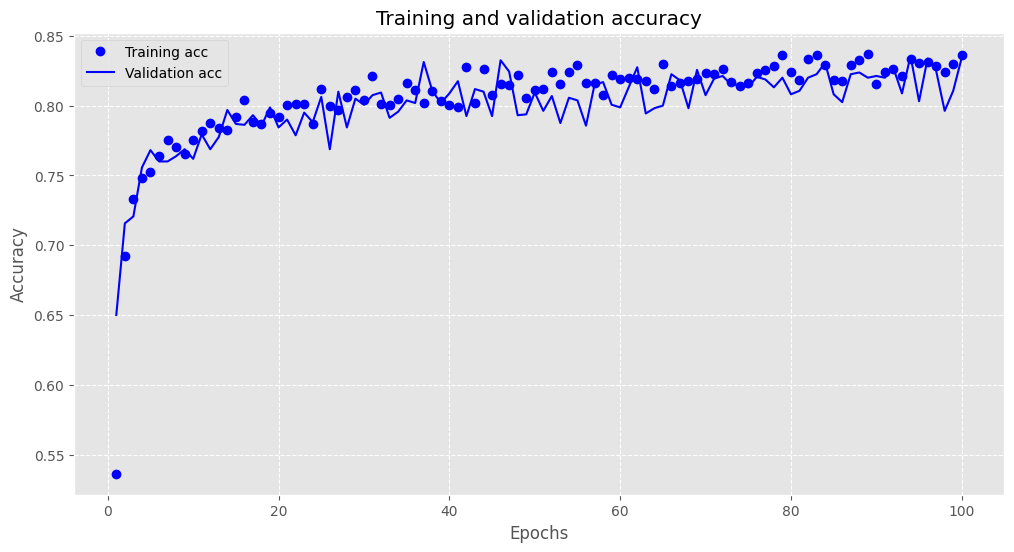

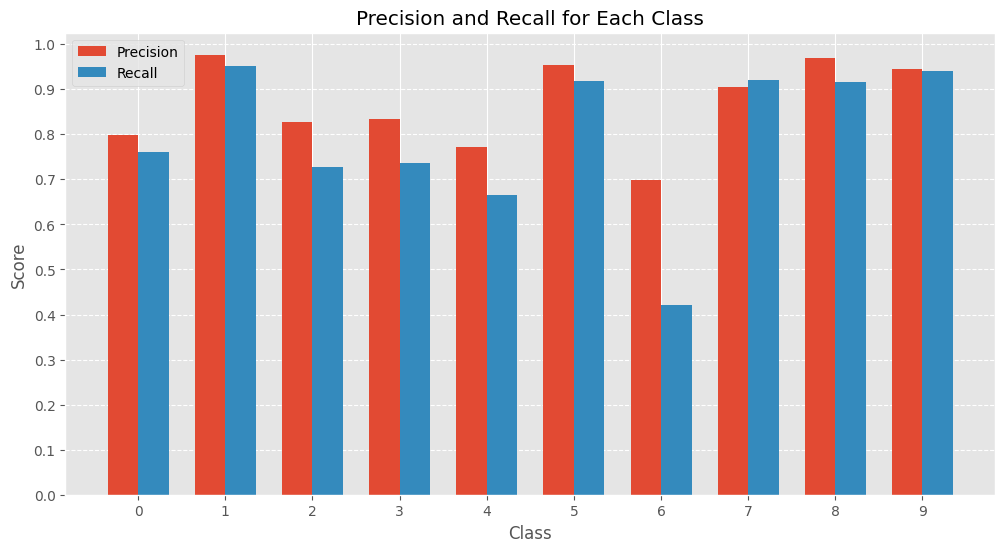

In [9]:
plot_history(history)
plot_precision_recall(history)

In [10]:
model_filter.save("D:\\My_Projects_Python\\HW_Data_Science\\models\\fashion_model_feature_extraction.keras")

In [11]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block4_conv3":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

class MyModifiedModel():
    def build(self):
        model = Sequential([
            conv_base,
            Flatten(),
            Dense(
                units=64,
                activation='relu'
            ),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model

In [12]:
modifiedmodel = MyModifiedModel()
model_modified = modifiedmodel.build()
history = model_modified.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=50,
    epochs=100,
    batch_size=32
)

Epoch 1/100
100/100 [==============================] - 34s 317ms/step - loss: 1.5178 - accuracy: 0.3991 - precision_class_0: 0.7388 - precision_class_1: 0.9403 - precision_class_2: 0.7107 - precision_class_3: 0.7337 - precision_class_4: 0.7676 - precision_class_5: 0.8352 - precision_class_6: 0.7642 - precision_class_7: 0.7467 - precision_class_8: 0.9211 - precision_class_9: 0.8138 - recall_class_0: 0.2220 - recall_class_1: 0.6335 - recall_class_2: 0.2789 - recall_class_3: 0.3047 - recall_class_4: 0.2300 - recall_class_5: 0.7269 - recall_class_6: 0.1623 - recall_class_7: 0.5859 - recall_class_8: 0.4832 - recall_class_9: 0.6581 - val_loss: 1.3307 - val_accuracy: 0.5331 - val_precision_class_0: 0.0000e+00 - val_precision_class_1: 0.6187 - val_precision_class_2: 0.0000e+00 - val_precision_class_3: 0.8750 - val_precision_class_4: 0.0000e+00 - val_precision_class_5: 0.9324 - val_precision_class_6: 0.0000e+00 - val_precision_class_7: 0.4845 - val_precision_class_8: 0.9906 - val_precision_clas

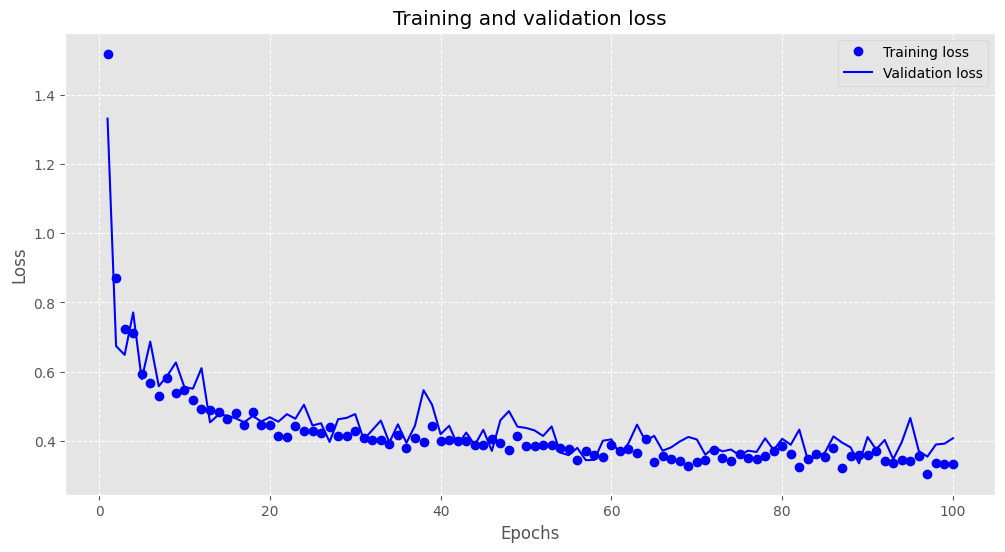

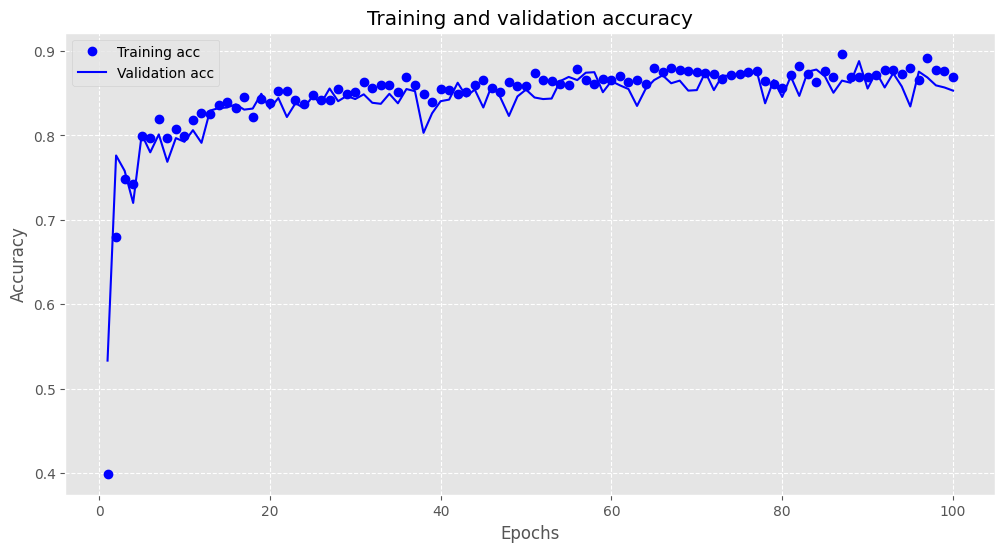

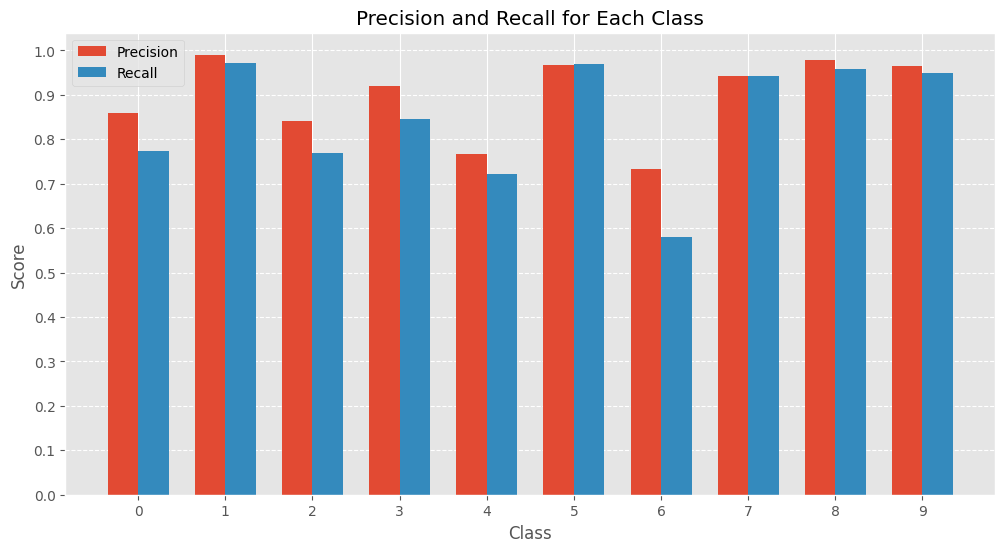

In [13]:
plot_history(history)
plot_precision_recall(history)

In [14]:
test_acc = model_modified.evaluate_generator(test_generator, steps=50)
print("test acc:", test_acc)

C:\Users\Asmod\AppData\Local\Temp\ipykernel_1308\561705103.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_acc = model_modified.evaluate_generator(test_generator, steps=50)


test acc: [0.35795554518699646, 0.8743749856948853, 0.8305084705352783, 0.9428571462631226, 0.8385416865348816, 0.895061731338501, 0.7272727489471436, 0.9642857313156128, 0.8987341523170471, 0.9151515364646912, 0.9554139971733093, 0.97826087474823, 0.854651153087616, 0.976331353187561, 0.8797814249992371, 0.8146067261695862, 0.7887324094772339, 0.9375, 0.45512819290161133, 0.9556962251663208, 0.9740259647369385, 0.9375]


# Висновки:

З-за допомогою передвиборних мереж мені не вдалося покращити результат попередньої моделі